In [ ]:
# !pip install gudhi
# !pip install tensorflow-addons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, cifar10
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, ReLU, LeakyReLU, Input, BatchNormalization, Lambda, Concatenate, Layer

# from tensorflow_addons.image import euclidean_dist_transform
from scipy.ndimage import distance_transform_edt as euclidean_dist_transform

import gudhi as gd
from gudhi.tensorflow import CubicalLayer

import multiprocessing
from multiprocessing import Pool

tf.config.run_functions_eagerly(True)

2023-02-28 15:55:56.757010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 15:55:56.993421: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
def sedt(x, zero_boundary=True):
    """Returns the signed euclidean distance transform (EDT) of a binary data array (of any dimension).

    When the boundary is considered zero distance, the EDT for an N-dimensional 
    binary data array computes a new array of equal shape where each cell is the 
    euclidean distance to the nearest boundary 1.

    In the signed EDT, the distance is considered positive if the corresponding 
    cell is outside the object and negative if it's inside.

    Args:
      x: Binary data array (of any dimension).
      zero_boundary: Whether pixels' at the object's boundary should distance 0 (default) or 1.
    
    Returns:
      New data array of signed euclidean distance transform.
    """

    if zero_boundary:
      # boundary = tf.cast(euclidean_dist_transform(x) == 1, tf.uint8)
      boundary = euclidean_dist_transform(x) == 1
      return euclidean_dist_transform(1 - x) - euclidean_dist_transform(x - boundary)
    
    return euclidean_dist_transform(1 - x) - euclidean_dist_transform(x)

In [ ]:
(x_train, y_train), _ = mnist.load_data()
x_train = x_train[y_train == 6]  # only keep 6s
# x_train = np.expand_dims(x_train, axis=-1).astype('float32')  
# x_train = (x_train / 255.) > 0 #* 2 - 1  # generator output will be mapped to [-1, 1] so we do the same here
x_train = np.array([sedt((x > 0).astype(np.uint8)) for x in x_train])
x_train = x_train / np.abs(x_train).max(axis=(1, 2)).reshape(-1, 1, 1)
x_train = np.expand_dims(x_train, axis=-1)  # quick hack: model expects img shape (28, 28, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

2023-02-28 15:56:00.782020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 15:56:00.895409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 15:56:00.895692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 15:56:00.898485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 15:56:00.898726: I tensorflow/compile

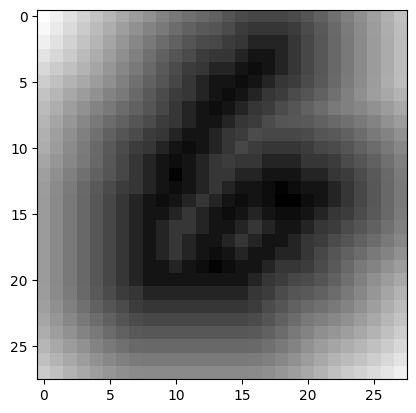

In [ ]:
plt.imshow(x_train[0, :, :, 0], cmap="gray")

## Generator Network

In [ ]:
def create_generator(latent_dim):
  gen_model = Sequential()
  d = 7

  # creates a 7x7 image from noise
  gen_model.add(Dense(128*d*d, input_dim=latent_dim))
  gen_model.add(ReLU())
  gen_model.add(BatchNormalization(momentum=0.8))
  gen_model.add(Reshape((d, d, 128)))

  # upsamples image to 14x14
  gen_model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  gen_model.add(ReLU())
  gen_model.add(BatchNormalization(momentum=0.8))

  # upsamples image to 28x28 (same as mnist data)
  gen_model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  gen_model.add(ReLU())
  gen_model.add(BatchNormalization(momentum=0.8))

  gen_model.add(Conv2D(1, (d, d), activation='tanh', padding='same'))

  gen_model = Model(gen_model.inputs, gen_model.outputs)
  
  return gen_model

## Discriminator Network

In [ ]:
# Since the model is small and BatchNorms should be avoided near the output, none are present here

class Topo(Layer):
  def __init__(self):
    super().__init__()
    self.cl = CubicalLayer(homology_dimensions=[0, 1])
    self.dimensions = [0, 1]

  def call(self, inputs):
    with tf.device('/cpu:0'):
      np_inputs = np.array(inputs.numpy(), copy=True)
      with Pool(6) as p:
        indices = p.map(self.get_persistence_indices, np_inputs)
    

    h0_indices, h1_indices = list(zip(*indices))  # unzips list of tuples: [(a, 1), (b, 2)] -> ([a, b], [1, 2])

    # the input to the vectorized_map must a tensor for optimization purposes
    # so we pad the indices with -1s to make them all the same length
    # and remove these when computing the persistence

    h0_len = max([len(h) for h in h0_indices])
    h1_len = max([len(h) for h in h1_indices])

    padded_h0 = -np.ones((len(h0_indices), h0_len, 2))
    padded_h1 = -np.ones((len(h1_indices), h1_len, 2))

    for real_indices in h0_indices:
      padded_h0[:, :len(real_indices)] = real_indices
    
    for real_indices in h1_indices:
      padded_h1[:, :len(real_indices)] = real_indices

    h0_indices = tf.convert_to_tensor(padded_h0, dtype=tf.int32)
    h1_indices = tf.convert_to_tensor(padded_h1, dtype=tf.int32)
    
    tf.config.run_functions_eagerly(False)
    out = tf.vectorized_map(self.get_persistence, (inputs, h0_indices, h1_indices))
    # out = tf.map_fn(self.get_persistence, (inputs, h0_indices, h1_indices), parallel_iterations=10)
    # out = [self.get_persistence((input_, h0_index, h1_index)) for input_, h0_index, h1_index in zip(inputs, h0_indices, h1_indices)]
    tf.config.run_functions_eagerly(True)

    return out
    # return tf.stack(out, axis=0)
  
  def compute_output_shape(self, input_shape):
    return tf.TensorShape([None, 2])

  def get_persistence_indices(self, x):
    cub_complex = gd.CubicalComplex(dimensions=x.shape[::-1], top_dimensional_cells=x.reshape(-1))
    cub_complex.compute_persistence()
    cofaces_pp = cub_complex.cofaces_of_persistence_pairs()

    indices = []
    for dim in self.dimensions:
      if dim < len(cofaces_pp[0]):
        indices.append(np.array(cofaces_pp[0][dim], dtype=np.int32))
      else:
        indices.append(np.array([-1, -1], dtype=np.int32))

    return indices

  @tf.function(reduce_retracing=True)
  def get_persistence(self, args):
    # this function is called by tf.vectorized_map which forces it to only do vector operations for performance reasons
    # so we have to do some weird stuff to get the pairs with positive persistence.
    # the comments should help a little but feel free to ask me any questions about this
    # ~Allan

    x, h0_indices, h1_indices = args

    dgms = []
    flat_img = tf.reshape(x, [-1])
    for indices in (h0_indices, h1_indices):
      finite_dgm = tf.reshape(tf.gather(flat_img, indices[indices != -1]), [-1, 2])  # find pixels that affect topological features

      persistent_indices_mask = tf.math.abs(finite_dgm[:, 1]-finite_dgm[:, 0]) > 0  # find pairs with positive persistence
      persistent_indices_mask = tf.stack([persistent_indices_mask, persistent_indices_mask], axis=-1)  # make it the same shape as finite_dgm
      finite_dgm = finite_dgm * tf.cast(persistent_indices_mask, finite_dgm.dtype)  # multiply pairs with negative persistence by 0

      finite_dgm = tf.reshape(finite_dgm, [-1, 2])
      dgms.append(finite_dgm)

    return self.vectorize_dgm(dgms[0], dgms[1])

  @tf.function(reduce_retracing=True)
  def vectorize_dgm(self, h0, h1):

    return tf.stack([
      tf.reduce_sum(h0**2),
      tf.reduce_sum(h1**2),
    ], axis=0)


def create_discriminator():

  input_tensor = Input(shape=(28, 28, 1))

  convo_layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1))(input_tensor)
  convo_layer = LeakyReLU(alpha=0.2)(convo_layer)
  convo_layer = Dropout(0.25)(convo_layer)
  
  convo_layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(convo_layer)
  convo_layer = LeakyReLU(alpha=0.2)(convo_layer)
  convo_layer = Dropout(0.25)(convo_layer)

  convo_layer = Flatten()(convo_layer)

  output = Dense(128)(convo_layer)
  output = LeakyReLU(alpha=0.2)(output)
  output = Dense(1, activation='sigmoid')(output)

  topo_inst = Topo()
  topo_inst.build(input_tensor.shape)
  topo_output = topo_inst(input_tensor)

  disc_model = Model(input_tensor, outputs=[output, topo_output])

  return disc_model

# Generating Inputs to discriminator and GAN

In [ ]:
@tf.function
def generate_latent_points(latent_dim, n_samples):
  """Samples noise in R^{latent_dim} to be fed into generator model"""

  return tf.random.normal((n_samples, latent_dim))  # sampled from normal dist
  # return tf.reshape(input_noise, (n_samples, latent_dim))


@tf.function
def generate_fake_examples(generator_model, latent_dim, n_samples):
  """Returns fake images and labels from generator model"""

  input_noise = generate_latent_points(latent_dim, n_samples)
  generated_imgs = generator_model(input_noise)
  labels = tf.zeros((n_samples, 1))  # for convenience, returns '0' labels (fake)
  return generated_imgs, labels


@tf.function
def generate_real_examples(dataset, n_samples):
  """Returns real images and labels from input dataset"""

  indices = tf.random.uniform(shape=(n_samples, ), maxval=len(dataset), dtype=tf.int32)
  real_imgs = tf.gather(dataset, indices, axis=0)
  labels = tf.ones((n_samples, 1))  # for convenience, returns '1' labels (real)
  return real_imgs, labels

# Train GAN

In [ ]:
def save_plot(examples, epoch):
    """Saves a plot of n x n generated images"""
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))

    for i, ax in enumerate(axs.flat):
        ax.imshow(examples[i, :, :, 0], cmap='gray')
        ax.axis('off')

    filename = 'generated_plot_e%03d.png' % (epoch+1)
    fig.savefig(filename)
    plt.close(fig)

In [ ]:
@tf.function
def compute_grad_penalty(gen_model, disc_model, latent_points, x_real, n_samples):
    epsilon = tf.random.uniform(shape=(n_samples // 2, 1, 1, 1), minval=0, maxval=1)

    with tf.GradientTape() as gp_tape:
        x_fake = gen_model(latent_points, training=True)
        mixed_batch = epsilon * x_fake + (1 - epsilon) * x_real
        pred, _ = disc_model(mixed_batch, training=True)
    
    grads = gp_tape.gradient(pred, mixed_batch)
    grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3)))
    gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

    return gradient_penalty


@tf.function
def disc_train_step(gen_model, disc_model, disc_optimizer, x_real, latent_dim, n_samples, gp_lambda, topo_lambda):
    latent_points = generate_latent_points(latent_dim, n_samples // 2)

    with tf.GradientTape(persistent=True) as d_tape:
        x_fake = gen_model(latent_points, training=True)
        gradient_penalty = compute_grad_penalty(gen_model, disc_model, latent_points, x_real, n_samples)

        y_fake, topo_fake = disc_model(x_fake, training=True)
        y_real, topo_real = disc_model(x_real, training=True)

        topo_loss = (tf.reduce_mean(topo_fake[:, 0]) - tf.reduce_mean(topo_real[:, 0]))**2 + \
            (tf.reduce_mean(topo_fake[:, 1]) - tf.reduce_mean(topo_real[:, 1]))**2
        tf.print('topo_loss: ', topo_loss)

        disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_real) + gp_lambda * gradient_penalty + \
            topo_lambda * topo_loss
    
    disc_grads = d_tape.gradient(disc_loss, disc_model.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_variables))

    return tf.reduce_mean(disc_loss)  # returns average loss


@tf.function
def gen_train_step(gen_model, disc_model, gen_optimizer, latent_dim, n_samples):
    latent_points = generate_latent_points(latent_dim, n_samples)

    with tf.GradientTape() as g_tape:
        x_fake = gen_model(latent_points, training=True)
        y_fake, _ = disc_model(x_fake, training=True)
        gen_loss = -tf.reduce_mean(y_fake) #+ topo_lambda * tf.reduce_mean(tf.square(topo_fake))

    gen_grads = g_tape.gradient(gen_loss, gen_model.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_variables))

    return tf.reduce_mean(gen_loss)  # returns average loss

In [ ]:
def train(gen_model, disc_model, gen_optimizer, disc_optimizer, dataset, latent_dim, n_epochs=50, batch_size=256, n_critic=5, gp_lambda=10, topo_lambda=1e-3):
  batches_per_epoch = dataset.shape[0] // batch_size

  for epoch in range(n_epochs):
    epoch_loss = []

    for batch in range(batches_per_epoch):
        print(f"Epoch {epoch+1}: {batch+1}/{batches_per_epoch}")

        for _ in range(n_critic):
            x_real, _ = generate_real_examples(dataset, batch_size // 2)
            loss = disc_train_step(gen_model, disc_model, disc_optimizer, x_real, latent_dim, batch_size, gp_lambda, topo_lambda)
            epoch_loss.append(loss)
          
        gen_train_step(gen_model, disc_model, gen_optimizer, latent_dim, batch_size)

    print(f"Epoch {epoch+1} loss: {np.mean(epoch_loss)}")

    if epoch % 10 == 0:
      fake_examples, _ = generate_fake_examples(gen_model, latent_dim, 100)
      save_plot(fake_examples, epoch)

In [ ]:
latent_dim = 100

generator_model = create_generator(latent_dim)
discriminator_model = create_discriminator()
generator_optimizer = Adam(learning_rate=2e-4, beta_1=0., beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0., beta_2=0.9)
# cl = CubicalLayer(homology_dimensions=(0, 1))

In [ ]:
# generator_model.load_weights("generator_model_wgan_gp_persistence60.h5")
# discriminator_model.load_weights("discriminator_model_wgan_gp_persistence60.h5")

In [ ]:
generator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 6272)              633472    
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                     

In [ ]:
discriminator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   640         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 64)   0           ['conv2d_1[0][0]']               
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 64)   0           ['leaky_re_lu[0][0]']            
                                                                                            

In [ ]:
train(generator_model, discriminator_model, generator_optimizer, discriminator_optimizer, x_train, latent_dim,
      batch_size=2**9, n_epochs=100)

Epoch 1: 1/11


2023-02-28 15:56:05.786434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 15:56:06.194338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


topo_loss:  35461.9453


topo_loss:  34902.8594
topo_loss:  35517.1
topo_loss:  35188.832
topo_loss:  34903.625
Epoch 1: 2/11
topo_loss:  35270.8672
topo_loss:  37354.6875
topo_loss:  34193.4453
topo_loss:  34213.2344
topo_loss:  35542.7578
Epoch 1: 3/11
topo_loss:  35640.1211
topo_loss:  36336.2812
topo_loss:  37055.1172
topo_loss:  36852.418
topo_loss:  38300.7891
Epoch 1: 4/11
topo_loss:  35929.6445
topo_loss:  36328.9102
topo_loss:  37943.0117
topo_loss:  37758.7578
topo_loss:  37358.9609
Epoch 1: 5/11
topo_loss:  43950.5742
topo_loss:  37097.6875
topo_loss:  40820.2461
topo_loss:  40733.0664
topo_loss:  37740.25
Epoch 1: 6/11
topo_loss:  43836.8867
topo_loss:  42049.3438
topo_loss:  43516.5273
topo_loss:  42610.5859
topo_loss:  43217.3
Epoch 1: 7/11
topo_loss:  43061.5352
topo_loss:  45015.1211
topo_loss:  44085.3516
topo_loss:  41406.3398
topo_loss:  43241.5391
Epoch 1: 8/11
topo_loss:  46638.8555
topo_loss:  42899.8398
topo_loss:  44811.0742
topo_loss:  45016.0469
topo_loss:  47984.7109
Epoch 1: 9/11
to

In [ ]:
fake_examples, _ = generate_fake_examples(generator_model, latent_dim, 100)
# fake_examples = (fake_examples + 1) / 2  # remap tanh output to [0, 1]
fake_examples = tf.cast(fake_examples < 0, tf.uint8) # binarize

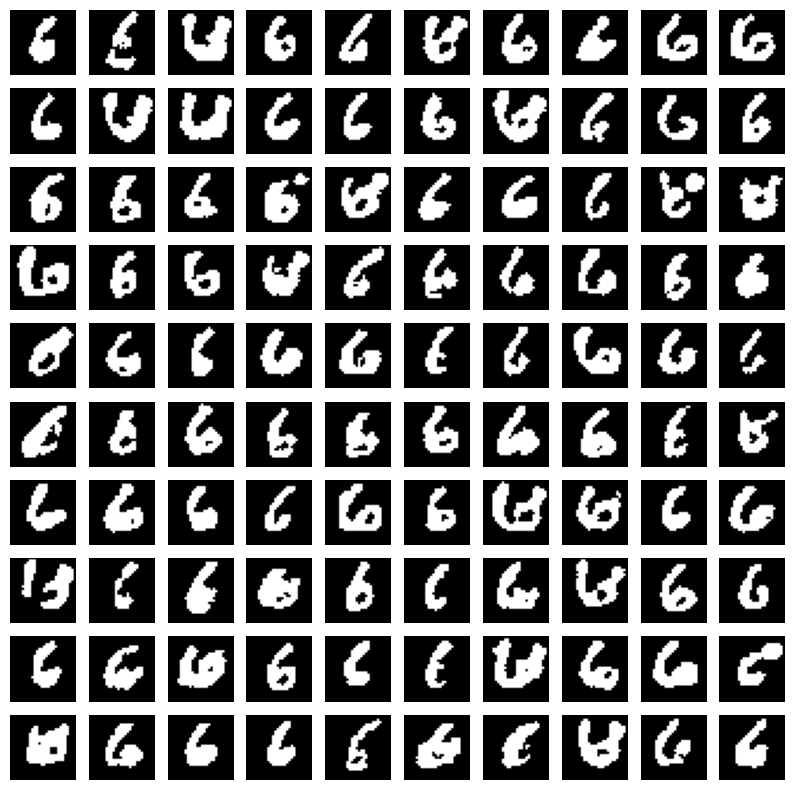

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
  # plot raw pixel data
  ax.imshow(fake_examples[i, :, :, 0], cmap='gray')
  ax.axis('off')

fig.savefig('with_topo.png')

In [ ]:
# save models
generator_model.save_weights("generator_model_wgan_gp_persistence_regularizer200epochs.h5")
discriminator_model.save_weights("discriminator_model_wgan_gp_persistence_regularizer200epochs.h5")

# References

- ### Blogpost on Mnist GAN

  Implementation based on this [blogpost](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/).

- ### DCGANs blogpost and paper

  Some tiny changes (such as adding batch norms and changing to tanh) are based on the results of this [paper](https://arxiv.org/pdf/1511.06434.pdf) and this [implementation](https://github.com/mitchelljy/DCGAN-Keras/blob/master/DCGAN.py) of the paper's architecture which are well summarized on this [blogpost](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/#:~:text=Use%20Batch%20Normalization&text=Batch%20normalization%20has%20become%20a,and%20input%20to%20the%20discriminator). DCGANs are used to improve training of GANs on a deep learning context but the results after training (even for a small model) looked slightly better so they were adopted here.

- ### Google Developers Blog on GANs

  Great [resource](https://developers.google.com/machine-learning/gan) though not specifically used on this implementation.

- ### WGAN-GP Reference code

  The code for the WGAN-GP was based on this [implementation](https://github.com/henry32144/wgan-gp-tensorflow/blob/master/WGAN-GP-celeb64.ipynb).